In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vpapenko/nails-segmentation")

print("Path to dataset files:", path)

/home/pgurzhii/miniforge3/envs/hic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/pgurzhii/.cache/kagglehub/datasets/vpapenko/nails-segmentation/versions/1


In [3]:
!cp -r /home/pgurzhii/.cache/kagglehub/datasets/vpapenko/nails-segmentation/versions/1 .

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
class NailsDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, image_extensions=['.jpg', '.jpeg', '.png']):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_extensions = image_extensions

        # Собираем только файлы с указанными расширениями
        self.image_names = [
            fname for fname in os.listdir(image_dir)
            if os.path.isfile(os.path.join(image_dir, fname)) and fname.lower().endswith(tuple(image_extensions))
        ] # список названий всех картинок с удовлетворяющим расширением

    def __len__(self):
        return len(self.image_names) # возвращает количество картинок

    def __getitem__(self, idx): # обращение к изображению и его метке по индексу
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name)

        # Загружаем изображение и маску
        image = Image.open(img_path).convert("RGB")  # Убедимся, что изображение в RGB
        label = Image.open(label_path).convert("L")  # Убедимся, что маска в градациях серого

        if self.transform:
            image = self.transform(image)
            
            # Применяем трансформации к маске, но не нормализуем
            label = self.transform(label)

        # Преобразуем маску в бинарную (0 или 1)
        label = (label > 0.5).float()  # Порог 127 для значений [0, 255]
        
        # Бинарная маска — это изображение, где каждый пиксель принадлежит к одному из двух классов:
        # 0: фон
        # 1: ногти

        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor()          # Convert images to PyTorch tensors
])

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__() # вызов конструктора родительского класса

        def conv_block(in_channels, out_channels):
            return nn.Sequential( # контейнер, который позволяет объединять несколько операций в одну последовательную структуру.
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # изображение не уменьшаеься за счет паддинга
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # Блоки сверток, последовательно увеличивающие количество каналов
        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        # После каждого блока сверток применяется операция макс-пулинга, которая уменьшает размер изображения в 2 раза.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Блок, который обрабатывает самые глубокие и абстрактные признаки
        # Размеры минимальны, количество каналов максимально
        self.bottleneck = conv_block(512, 1024)

        # Транспонированная свертка увеличивает размер изображения в 2 раза
        self.upconv4 = up_conv(1024, 512)
        # Блоки сверток, которые обрабатывают объединенные тензоры и уменьшают количество каналов
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)

        # Изменен выход, теперь два канала
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)  # 2 канала для фона и объекта

    def forward(self, x):
        # x=(3, 256, 256)
        
        # энкодер
        enc1 = self.encoder1(x) # (64, 256, 256)
        enc2 = self.encoder2(self.pool(enc1)) # (64, 128, 128) -> (128, 128, 128) 
        enc3 = self.encoder3(self.pool(enc2)) # (128, 64, 64) -> (256, 64, 64)
        enc4 = self.encoder4(self.pool(enc3)) # (256, 32, 32) -> (512, 32, 32)

        # бутылочное горлышко
        bottleneck = self.bottleneck(self.pool(enc4)) # (512, 16, 16) -> (1024, 16, 16)

        # декодер
        dec4 = self.upconv4(bottleneck) # (512, 32, 32)
        # torch.cat - skip-connections с соответствующим тензором из кодировщика 
        # Они помогают сети сохранять детали изображения, которые могли быть потеряны в кодировщике
        # Конкатенация по каналам
        dec4 = torch.cat((dec4, enc4), dim=1) # (1024, 32, 32) = (512, 32, 32) + (512, 32, 32)
        dec4 = self.decoder4(dec4) # (512, 32, 32)

        dec3 = self.upconv3(dec4) # (256, 64, 64)
        dec3 = torch.cat((dec3, enc3), dim=1) # (512, 64, 64)
        dec3 = self.decoder3(dec3) # (256, 64, 64)

        dec2 = self.upconv2(dec3) # (128, 128, 128)
        dec2 = torch.cat((dec2, enc2), dim=1) # (256, 128, 128)
        dec2 = self.decoder2(dec2) # (128, 128, 128)

        dec1 = self.upconv1(dec2) # (64, 256, 256)
        dec1 = torch.cat((dec1, enc1), dim=1) # (128, 256, 256)
        dec1 = self.decoder1(dec1) # (64, 256, 256)

        return self.final_conv(dec1) # (2, 256, 256)

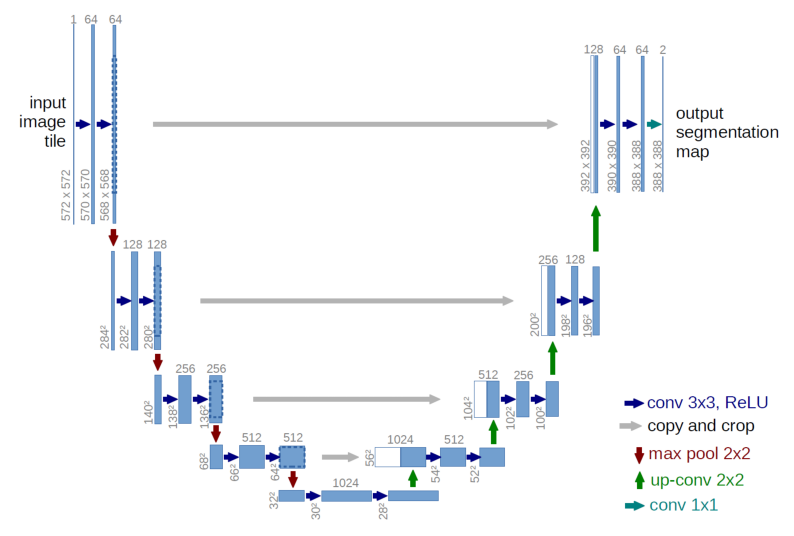

In [8]:
image = Image.open('u-net-architecture.png')
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')  
plt.show()

In [5]:
# Функция для подсчёта весов классов
def compute_class_weights(dataset):
    count_0, count_1 = 0, 0

    for img, mask in dataset:
        mask_np = mask.numpy()  # Преобразуем маску в numpy array
        count_0 += np.sum(mask_np == 0) # кол-во пикселей, принадлежащих фону
        count_1 += np.sum(mask_np == 1) # кол-во пикселей, принадлежащих ногтям

    total_pixels = count_0 + count_1
    freq_0 = count_0 / total_pixels # частота встречаемости пикселей фона
    freq_1 = count_1 / total_pixels # частота встречаемости пикселей ногтей

    weight_0 = 1 / freq_0 # вес класса фона
    weight_1 = 1 / freq_1 # вес класса ногтей

    return torch.tensor([weight_0, weight_1], dtype=torch.float32)

In [6]:
dataset = NailsDataset(image_dir='1/nails_segmentation/images', label_dir='1/nails_segmentation/labels', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
class_weights = compute_class_weights(dataset)
print("Class Weights:", class_weights)
# 0,95 - фон
# 0,05 - ногти

Class Weights: tensor([ 1.0511, 20.5650])


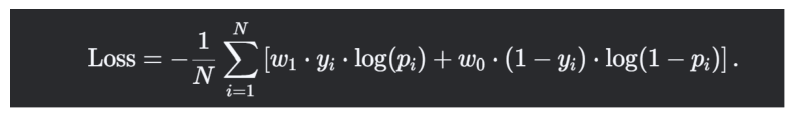

In [20]:
image = Image.open('weighted_cro.png')
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')  
plt.show()
# Веса классов увеличивают вклад ошибок для редкого класса

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

class_weights = compute_class_weights(dataset).to(device)

# Передаём веса в функцию потерь
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# Передача весов в функцию потерь нужна для балансировки вклада каждого класса в обучение модели
# Искуственно завышаем ошибку для представителей меньшего по объему класса

optimizer = optim.Adam(model.parameters(), lr=0.0001) 

full_loss = []
full_f1 = []

num_epochs = 250
for epoch in range(num_epochs):
    model.train() # Переводим модель в режим обучения
    epoch_loss = 0
    epoch_f1 = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Обнуление градиентов параметров модели перед каждым шагом обучения
        outputs = model(images) # (2, H, W)
        # Каждый пиксель описывается двумя значениями (принадлежность к классу фон (0) или ноготь (1))

        labels = (labels > 0.5).long()  
        if len(labels.shape) == 4:  
            labels = labels.squeeze(1)
        # squeeze(1) удаляет лишнюю размерность из тензора масок (размерность по индексу 1, если она равна 1)
        # labels.shape = (Batch, 1, Height, Width), после squeeze(1) получим (Batch, Height, Width).

        # Вычисление потерь
        loss = criterion(outputs, labels)
        loss.backward() # Вычисление градиентов функции потерь по параметрам модели
        optimizer.step() # Обновление весов на основе вычисленных градиентов

        epoch_loss += loss.item() # Значение loss для batch

        # Вычисление F1 score для оценки качества модели
        predicted = torch.argmax(outputs, dim=1)  # Применяем argmax для многоклассовой сегментации
        # Для каждого пикселя выбирает класс с максимальной вероятностью (0 или 1)
        # Получается тензор с предсказанными метками 

        f1 = f1_score(labels.cpu().numpy().flatten(), predicted.cpu().numpy().flatten(), average='binary')
        # .flatten(): преобразует многомерный массив NumPy в одномерный
        epoch_f1 += f1
        
    full_loss.append(epoch_loss / len(train_loader))
    full_f1.append(epoch_f1 / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, F1 Score: {epoch_f1 / len(train_loader):.4f}")

Epoch [1/250], Loss: 0.6983, F1 Score: 0.0893
Epoch [2/250], Loss: 0.6976, F1 Score: 0.0876
Epoch [3/250], Loss: 0.6899, F1 Score: 0.1005
Epoch [4/250], Loss: 0.6939, F1 Score: 0.0867
Epoch [5/250], Loss: 0.6809, F1 Score: 0.1195
Epoch [6/250], Loss: 0.6742, F1 Score: 0.1420
Epoch [7/250], Loss: 0.6809, F1 Score: 0.1084
Epoch [8/250], Loss: 0.6697, F1 Score: 0.1385
Epoch [9/250], Loss: 0.6642, F1 Score: 0.1302
Epoch [10/250], Loss: 0.6561, F1 Score: 0.1505
Epoch [11/250], Loss: 0.6018, F1 Score: 0.2075
Epoch [12/250], Loss: 0.6457, F1 Score: 0.1353
Epoch [13/250], Loss: 0.6164, F1 Score: 0.1405
Epoch [14/250], Loss: 0.5889, F1 Score: 0.1488
Epoch [15/250], Loss: 0.5871, F1 Score: 0.1535
Epoch [16/250], Loss: 0.5990, F1 Score: 0.1732
Epoch [17/250], Loss: 0.6293, F1 Score: 0.1422
Epoch [18/250], Loss: 0.5688, F1 Score: 0.1548
Epoch [19/250], Loss: 0.6091, F1 Score: 0.1182
Epoch [20/250], Loss: 0.5703, F1 Score: 0.1685
Epoch [21/250], Loss: 0.5834, F1 Score: 0.1583
Epoch [22/250], Loss: 

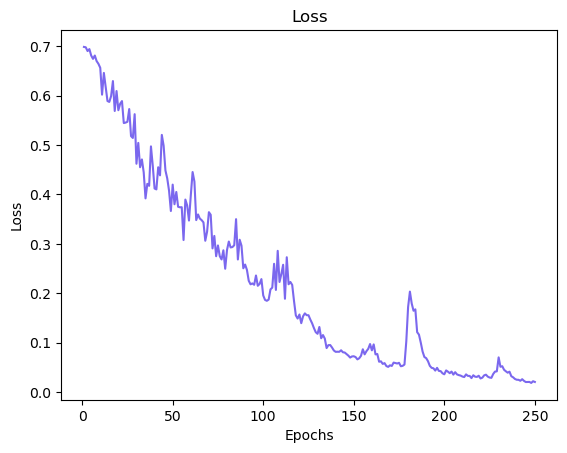

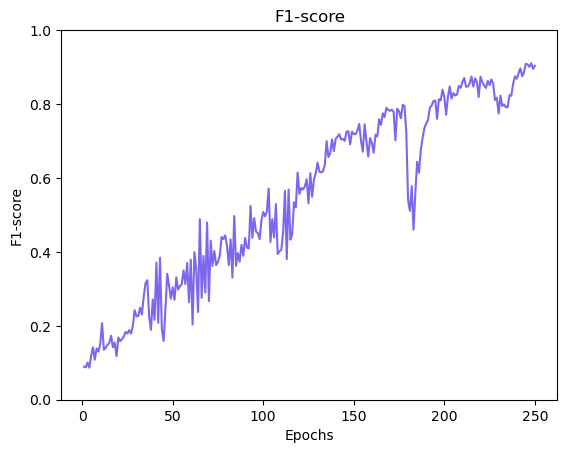

In [13]:
plt.plot(range(1,251), full_loss, color="#7B68EE")
plt.xlabel('Epochs') 
plt.ylabel('Loss')  
plt.title('Loss') 
plt.savefig('Loss_without_regularization.png')

plt.show()

plt.plot(range(1,251), full_f1, color="#7B68EE")
plt.xlabel('Epochs') 
plt.ylabel('F1-score')  
plt.ylim([0, 1])
plt.title('F1-score') 
plt.savefig('F1_score_without_regularization.png')

plt.show()

In [20]:
from torchmetrics import JaccardIndex

# Инициализация метрики
jaccard = JaccardIndex(task="binary", num_classes=2).to(device)

model.eval()
total_iou = 0
num_batches = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Преобразуем логиты в предсказания
        preds = torch.argmax(outputs, dim=1)
        labels = labels.squeeze(1)
        
        # Обновляем метрику
        jaccard.update(preds, labels)
        num_batches += 1

# Средний IoU по всем батчам
mean_iou = jaccard.compute()
print(f"Mean IoU on test set: {mean_iou:.4f}")

Mean IoU on test set: 0.1441


In [27]:
from torchmetrics import Dice
# Инициализация метрики Dice Coefficient
dice_score = Dice()

model.eval()
total_dice_score = 0
num_batches = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # (batch_size, 2, H, W)
        outputs = outputs[:, 1, :, :].unsqueeze(1)  # (batch_size, 1, H, W)
        
        # Преобразуем метки в формат (batch_size, 1, H, W)
        labels = labels.unsqueeze(1).long()
        
        # Вычисляем Dice Coefficient для текущего батча
        batch_dice_score = dice_score(outputs, labels).item()
        total_dice_score += batch_dice_score
        num_batches += 1

# Средний Dice Coefficient по всем батчам
mean_dice_score = total_dice_score / num_batches
print(f"Mean Dice Coefficient (F1-Score) on test set: {mean_dice_score:.4f}")

Mean Dice Coefficient (F1-Score) on test set: 0.3335


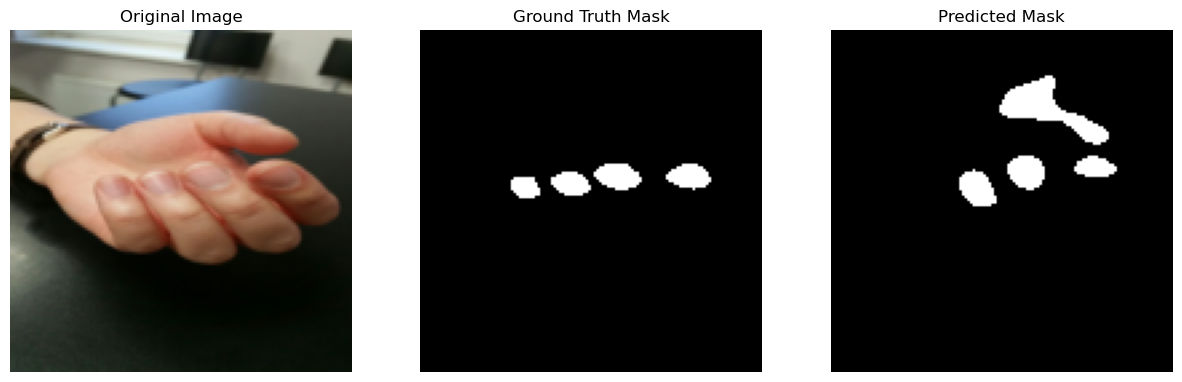

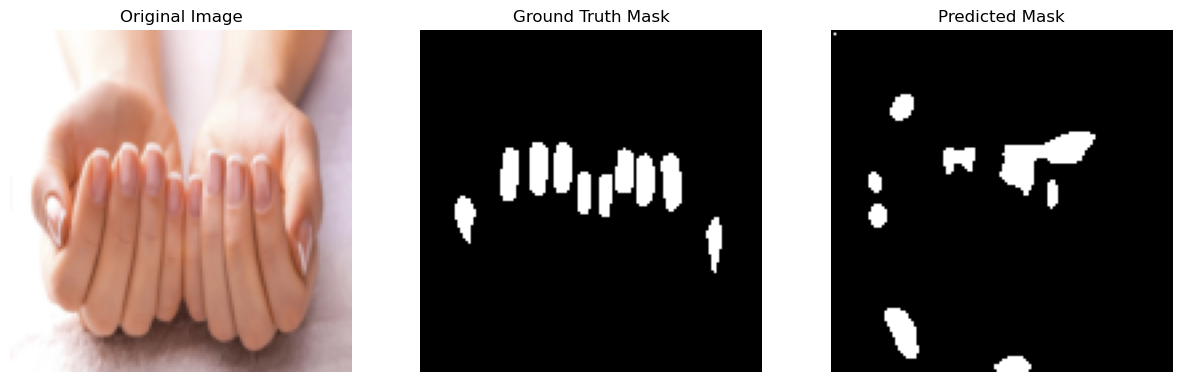

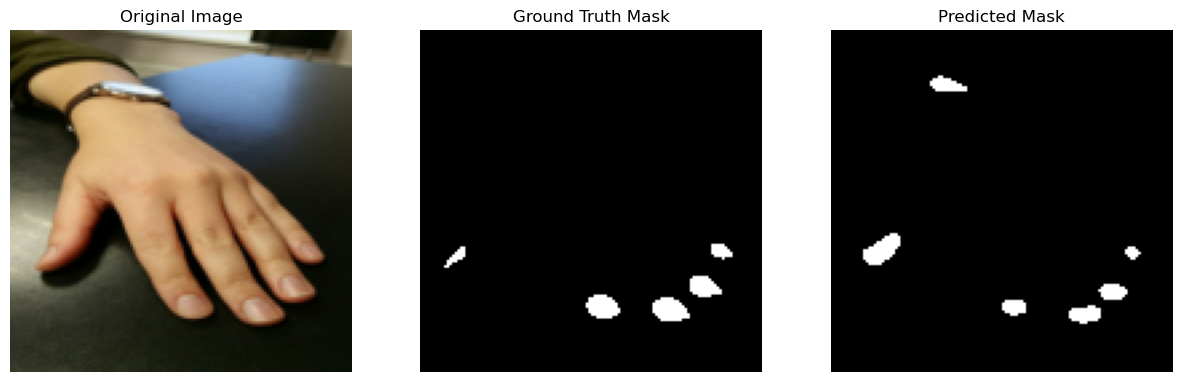

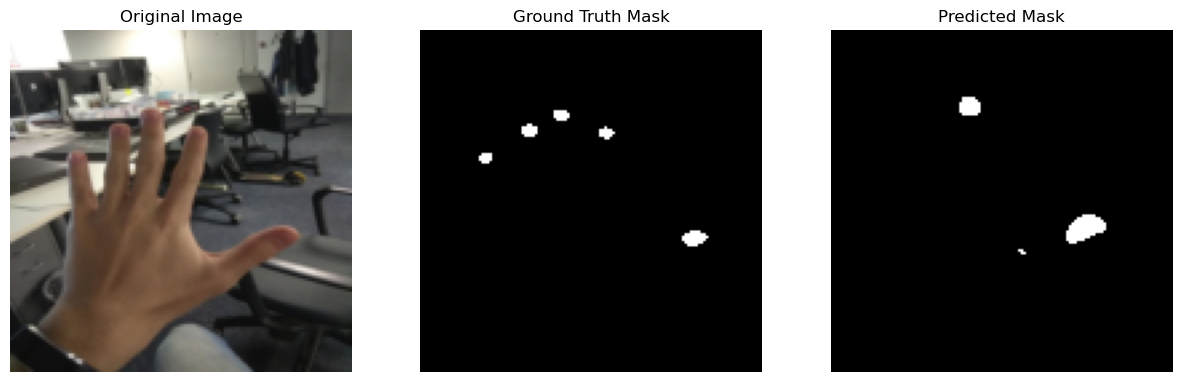

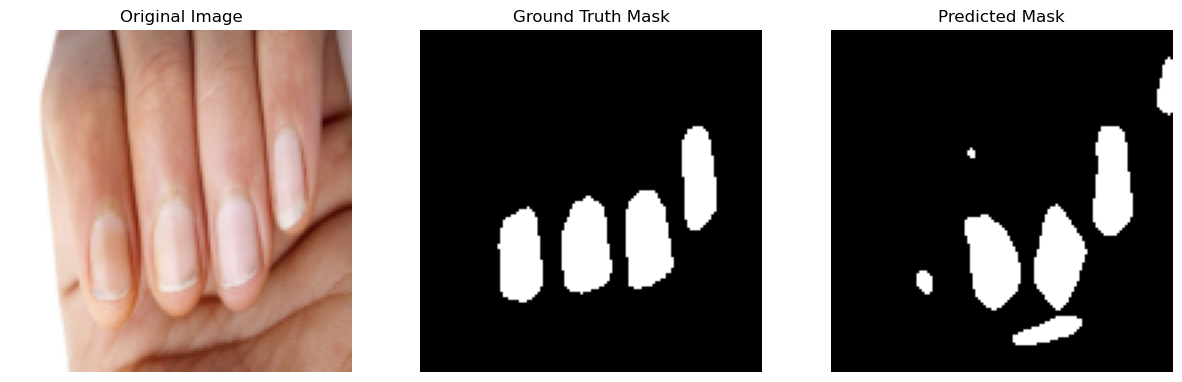

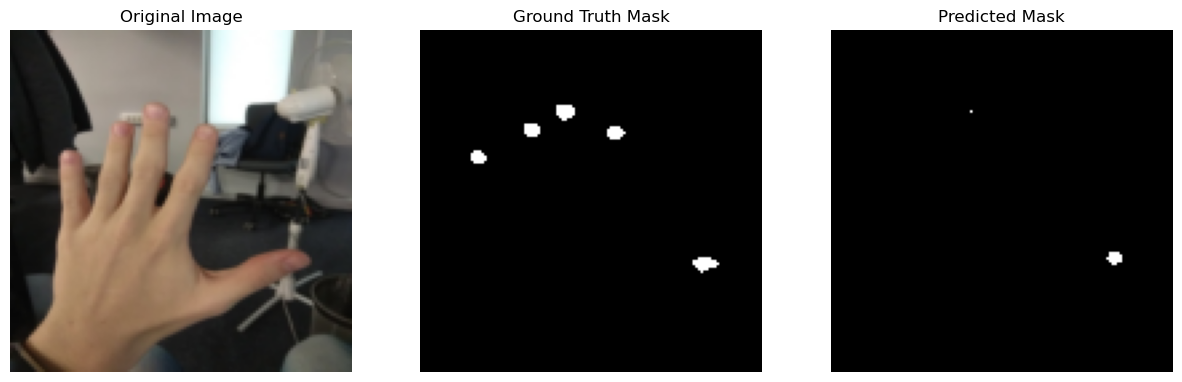

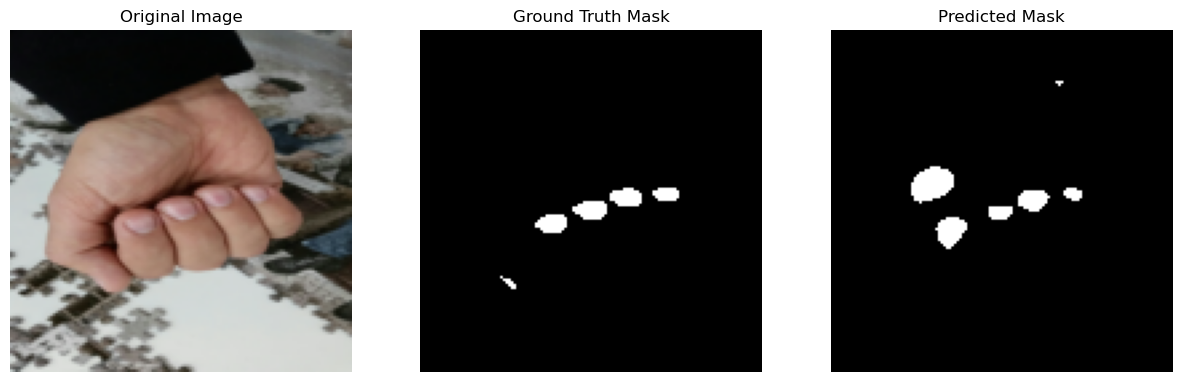

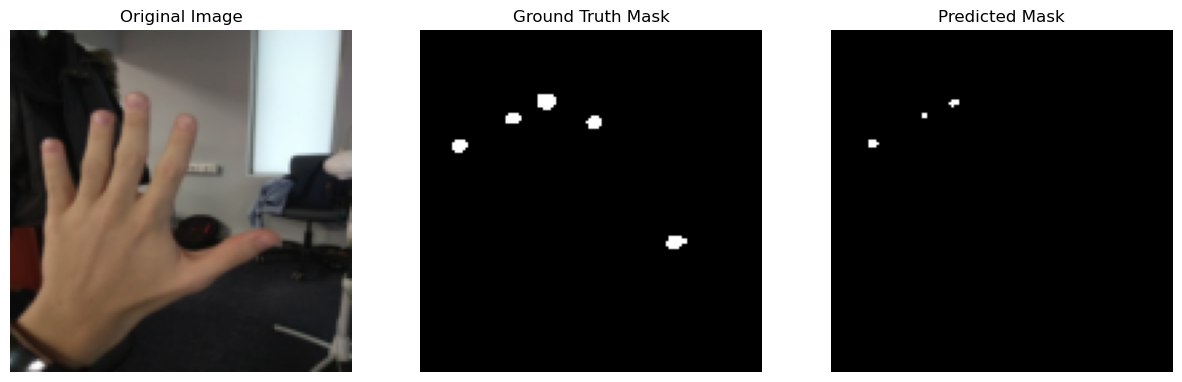

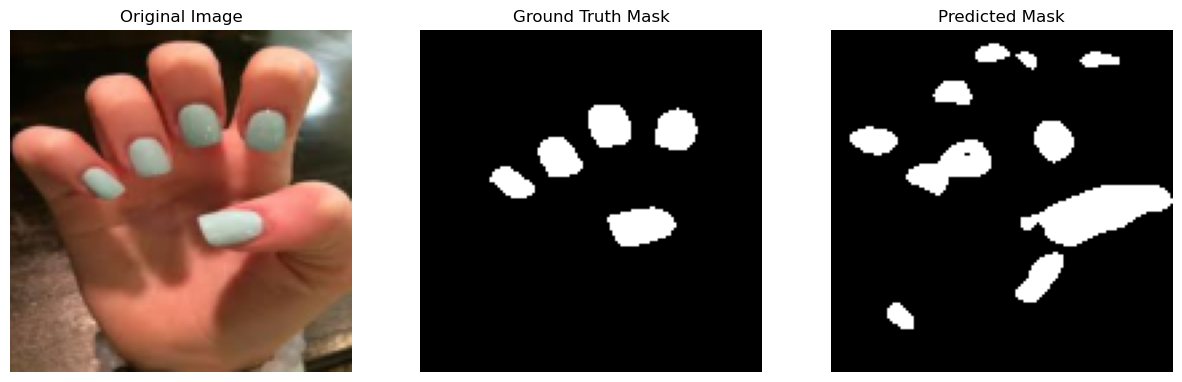

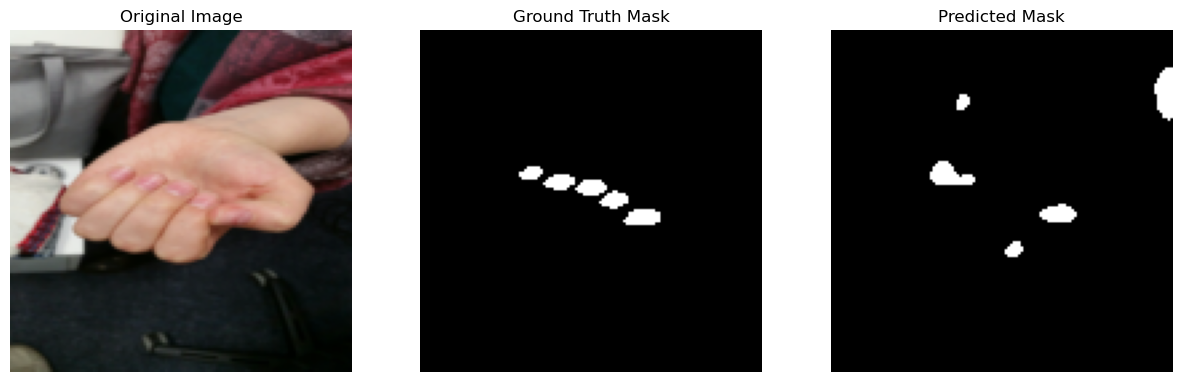

In [12]:
import matplotlib.pyplot as plt
import random

# Выбираем случайные индексы для визуализации
indices = random.sample(range(len(test_dataset)), 10)

model.eval()
with torch.no_grad():
    for idx in indices:
        image, label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Добавляем batch dimension
        output = model(image)
        
        # Применяем порог к предсказаниям
        output = (output > 0.5).float()
        
        # Преобразуем логиты в вероятности с помощью softmax
#         output = torch.softmax(output, dim=1)  # (1, 2, H, W)
        
#         # Выбираем класс с максимальной вероятностью
#         output = torch.argmax(output, dim=1)  # (1, H, W)
        
        # Переводим тензоры в numpy для визуализации
        image = image.squeeze().cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        label = label.squeeze().cpu().numpy()
        output = output.squeeze().cpu().numpy()

# Если output имеет 2 канала, выбираем только один (обычно класс 1)
        if output.ndim == 3:  # Проверяем, есть ли у тензора 3 измерения (C, H, W)
            output = output[1] 
        
        # Визуализация
        plt.figure(figsize=(15, 5))
        
        # Оригинальное изображение
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.axis('off')
        plt.imshow(image)
        
        # Маска (лейбл)
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.axis('off')
        plt.imshow(label, cmap='gray')
        
        # Предсказание модели
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.axis('off')
        plt.imshow(output, cmap='gray')
        
        plt.show()

In [15]:
sample_image, sample_label = dataset[0]

# Проверка изображения
print(f"Image shape: {sample_image.shape}")
print(f"Image min: {sample_image.min().item()}, Image max: {sample_image.max().item()}")

# Проверка маски
print(f"Label shape: {sample_label.shape}")
print(f"Label min: {sample_label.min().item()}, Label max: {sample_label.max().item()}")

Image shape: torch.Size([3, 128, 128])
Image min: 0.03529411926865578, Image max: 1.0
Label shape: torch.Size([1, 128, 128])
Label min: 0.0, Label max: 1.0


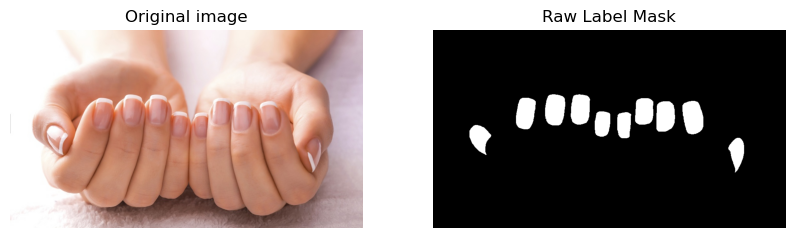

In [20]:
# Загружаем маску без трансформаций
index = 9
label_path = os.path.join(dataset.label_dir, dataset.image_names[index])
label = Image.open(label_path).convert("L")  # Убедимся, что маска в градациях серого
image_path = os.path.join(dataset.image_dir, dataset.image_names[index])
image = Image.open(image_path).convert("RGB")  # Убедимся, что маска в градациях серого

# Визуализация
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Raw Label Mask")
plt.imshow(label, cmap='gray')
plt.axis('off')
#plt.colorbar()

plt.savefig('example_of_pic', bbox_inches="tight")
plt.show()

# Проверка значений пикселей
# label_array = np.array(label)
# print(f"Label unique values: {np.unique(label_array)}")
# print(f"Label min: {label_array.min()}, Label max: {label_array.max()}")